In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch

In [150]:
df1 = pd.read_csv(r'../Data/deliveries.csv')
df2 = pd.read_csv(r'../Data/route_conditions.csv')
df3 = pd.read_csv(r'../Data/routes.csv')

In [151]:
df2.head(5)

,route_id,date,avg_temperature,rainfall_mm,weather_condition,traffic_level,road_incident_flag
0,1,2025-01-01,36.868677,6.675701,Clear,Medium,0
1,1,2025-01-02,17.663781,16.622596,Clear,Medium,0
2,1,2025-01-03,39.040286,0.000000,Clear,Low,0
3,1,2025-01-04,30.696596,2.073694,Fog,Medium,0
4,1,2025-01-05,34.992297,0.111139,Clear,Medium,0


In [152]:
# Convert date and time columns to datetime objects. This makes it easier to perform calculations like delays, durations, etc.
df1['dispatch_time'] = pd.to_datetime(df1['dispatch_time'])
df1['promised_delivery_time'] = pd.to_datetime(df1['promised_delivery_time'])
df1['actual_delivery_time'] = pd.to_datetime(df1['actual_delivery_time'])
df1['delivery_date'] = pd.to_datetime(df1['delivery_date'])

df2['date'] = pd.to_datetime(df2['date'])

In [153]:
"""
Standardization of column names for merging
"""
# Rename df1 delivery_date to 'date' to match df2
df1 = df1.rename(columns={'delivery_date': 'date'})

# Merge delivery info with weather/traffic data
# Join on route_id and date (left join to keep all deliveries)
df_merged = pd.merge(
    df1, df2,
    how='left',
    on=['route_id', 'date']
)

# Merge with route metadata
# Join on route_id to get route_name, origin/destination coordinates, region, etc.
df_merged = pd.merge(
    df_merged, df3,
    how='left',
    on='route_id'
)

# Preview merged dataframe
df_merged.head()

,delivery_id,order_id,route_id,carrier_type,dispatch_time,promised_delivery_time,actual_delivery_time,delivery_distance_km,delay_minutes,date,...,rainfall_mm,weather_condition,traffic_level,road_incident_flag,route_name,origin_latitude,origin_longitude,destination_latitude,destination_longitude,route_region
0,1,93848,19,3PL Partner,2025-05-04 12:00:00,2025-05-04 12:24:27.744879,2025-05-04 12:44:06.977741,6.34,19.7,2025-05-04,...,0.00000,Storm,High,0,Route_19,19.667926,83.474035,13.519114,78.392065,South
1,2,34127,2,3PL Partner,2025-06-28 06:00:00,2025-06-28 07:12:51.494899,2025-06-28 07:04:18.480267,15.86,-8.6,2025-06-28,...,0.00000,Clear,High,0,Route_2,27.916357,74.976104,20.673313,77.033045,West
2,3,67692,11,Bike,2025-02-21 03:00:00,2025-02-21 03:32:47.819755,2025-02-21 03:44:58.045286,7.24,12.2,2025-02-21,...,21.18668,Clear,High,0,Route_11,13.127293,82.277700,28.216396,84.847018,East
3,4,47500,13,Bike,2025-05-31 06:00:00,2025-05-31 09:01:27.946382,2025-05-31 09:03:06.540393,33.22,1.6,2025-05-31,...,0.00000,Clear,Low,1,Route_13,26.035838,73.814805,27.738033,72.886145,East
4,5,43785,15,Van,2025-05-23 10:00:00,2025-05-23 12:43:11.597939,2025-05-23 12:33:21.605408,38.73,-9.8,2025-05-23,...,24.84921,Storm,High,0,Route_15,15.691017,87.863860,22.306610,83.826975,Central


In [154]:
"""
Creation of a new column 'delivery_status' to categorize deliveries
Early   : delivered before promised time
On-time : delivered exactly at promised time
Delayed : delivered after promised time
"""
def categorize_delivery(row):
    if row['actual_delivery_time'] < row['promised_delivery_time']:
        return 'Early'
    elif row['actual_delivery_time'] == row['promised_delivery_time']:
        return 'On-time'
    else:
        return 'Delayed'

df_merged['delivery_status'] = df_merged.apply(categorize_delivery, axis=1)

# Extract the day of the week from dispatch_time for analysis
df_merged['day_of_week'] = df_merged['dispatch_time'].dt.day_name()

# Check how many deliveries fall into each category
df_merged['delivery_status'].value_counts()

df_merged.head(5)

,delivery_id,order_id,route_id,carrier_type,dispatch_time,promised_delivery_time,actual_delivery_time,delivery_distance_km,delay_minutes,date,...,traffic_level,road_incident_flag,route_name,origin_latitude,origin_longitude,destination_latitude,destination_longitude,route_region,delivery_status,day_of_week
0,1,93848,19,3PL Partner,2025-05-04 12:00:00,2025-05-04 12:24:27.744879,2025-05-04 12:44:06.977741,6.34,19.7,2025-05-04,...,High,0,Route_19,19.667926,83.474035,13.519114,78.392065,South,Delayed,Sunday
1,2,34127,2,3PL Partner,2025-06-28 06:00:00,2025-06-28 07:12:51.494899,2025-06-28 07:04:18.480267,15.86,-8.6,2025-06-28,...,High,0,Route_2,27.916357,74.976104,20.673313,77.033045,West,Early,Saturday
2,3,67692,11,Bike,2025-02-21 03:00:00,2025-02-21 03:32:47.819755,2025-02-21 03:44:58.045286,7.24,12.2,2025-02-21,...,High,0,Route_11,13.127293,82.277700,28.216396,84.847018,East,Delayed,Friday
3,4,47500,13,Bike,2025-05-31 06:00:00,2025-05-31 09:01:27.946382,2025-05-31 09:03:06.540393,33.22,1.6,2025-05-31,...,Low,1,Route_13,26.035838,73.814805,27.738033,72.886145,East,Delayed,Saturday
4,5,43785,15,Van,2025-05-23 10:00:00,2025-05-23 12:43:11.597939,2025-05-23 12:33:21.605408,38.73,-9.8,2025-05-23,...,High,0,Route_15,15.691017,87.863860,22.306610,83.826975,Central,Early,Friday


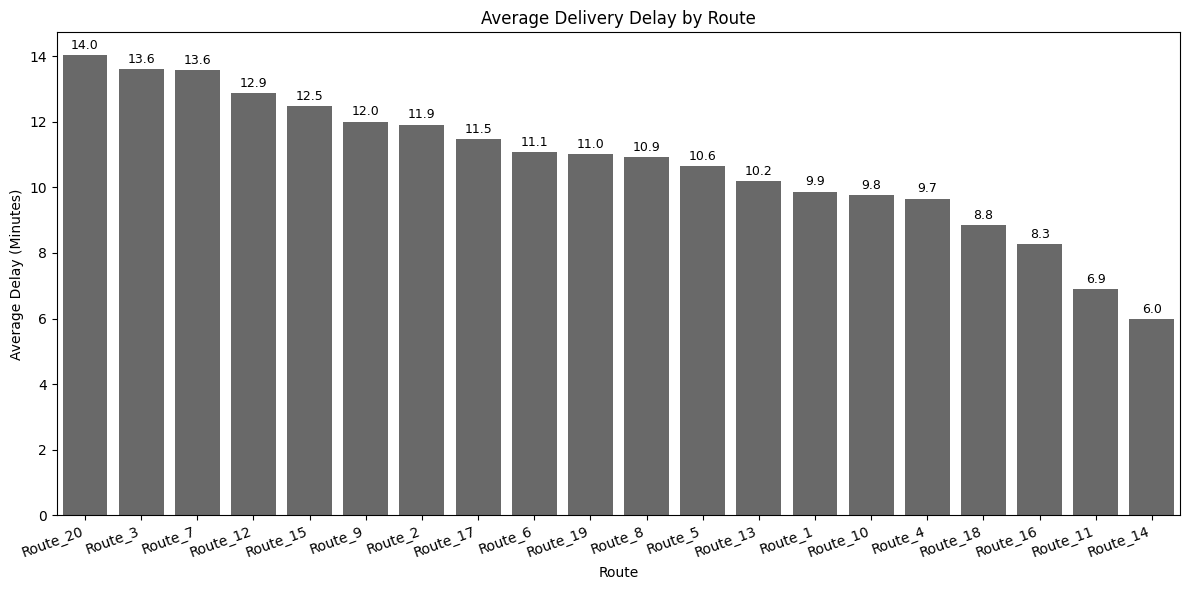

In [155]:
"""
PURPOSE:
This visual highlights which delivery paths experience the longest wait times. 
It ranks the top 20 routes based on their typical time behind schedule, 
helping to prioritize areas that need logistical improvement.
"""

# Calculate average delay per route and sort from highest to lowest
route_delays = df_merged.groupby('route_name')['delay_minutes'].mean().sort_values(ascending=False)

# Create a bar plot for the top 20 routes with highest average delays
plt.figure(figsize=(12,6))
bars = sns.barplot(
    x=route_delays.head(20).index, 
    y=route_delays.head(20).values, 
    color="#696969"  
)

# Extremely simple and professional formatting
plt.xticks(rotation=20, ha='right')
plt.ylabel("Average Delay (Minutes)")
plt.xlabel("Route")
plt.title("Average Delivery Delay by Route")
plt.tight_layout()

# Label each bar with its numeric value
for bar in bars.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  
        height + 0.1,                     
        f'{height:.1f}',                  
        ha='center', 
        va='bottom', 
        color='black', 
        fontsize=9                        
    )

plt.show()

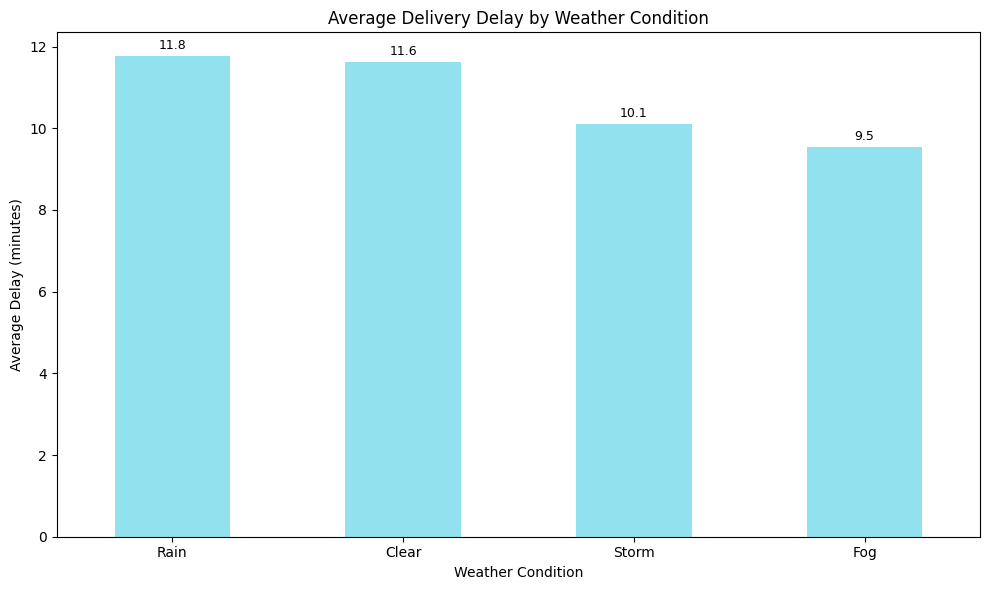

In [156]:
"""
Identification of the weather conditions with the highest average delivery delays.
"""

# Calculate average delay per weather condition
weather_delays = (
    df_merged.groupby('weather_condition')['delay_minutes']
    .mean()
    .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=weather_delays.index,
    y=weather_delays.values,
    color="#82EEFD"
)

# Editing the bar-width
new_width = 0.5
for bar in ax.patches:
    current_width = bar.get_width()
    diff = current_width - new_width

    bar.set_width(new_width)
    bar.set_x(bar.get_x() + diff / 2)

# Labels
plt.xticks(rotation=0)
plt.ylabel("Average Delay (minutes)")
plt.xlabel("Weather Condition")
plt.title("Average Delivery Delay by Weather Condition")
plt.tight_layout()

# Add value labels
for bar in ax.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.1,
        f'{height:.1f}',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.show()

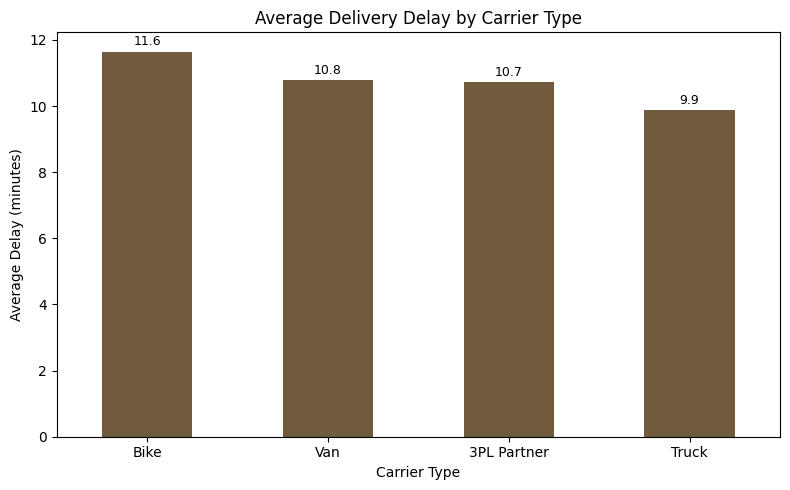

In [157]:
"""
Identification of the carriers with the highest average delivery delays.
"""

# Average delay per carrier type
carrier_delays = (
    df_merged.groupby('carrier_type')['delay_minutes']
    .mean()
    .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=carrier_delays.index,
    y=carrier_delays.values,
    color="#795C34"   
)

# Editing the bar-width
new_width = 0.5
for bar in ax.patches:
    current_width = bar.get_width()
    diff = current_width - new_width

    bar.set_width(new_width)
    bar.set_x(bar.get_x() + diff / 2)

# Labels
plt.ylabel("Average Delay (minutes)")
plt.xlabel("Carrier Type")
plt.title("Average Delivery Delay by Carrier Type")
plt.tight_layout()

# Add value labels
for bar in ax.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.1,
        f'{height:.1f}',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.show()

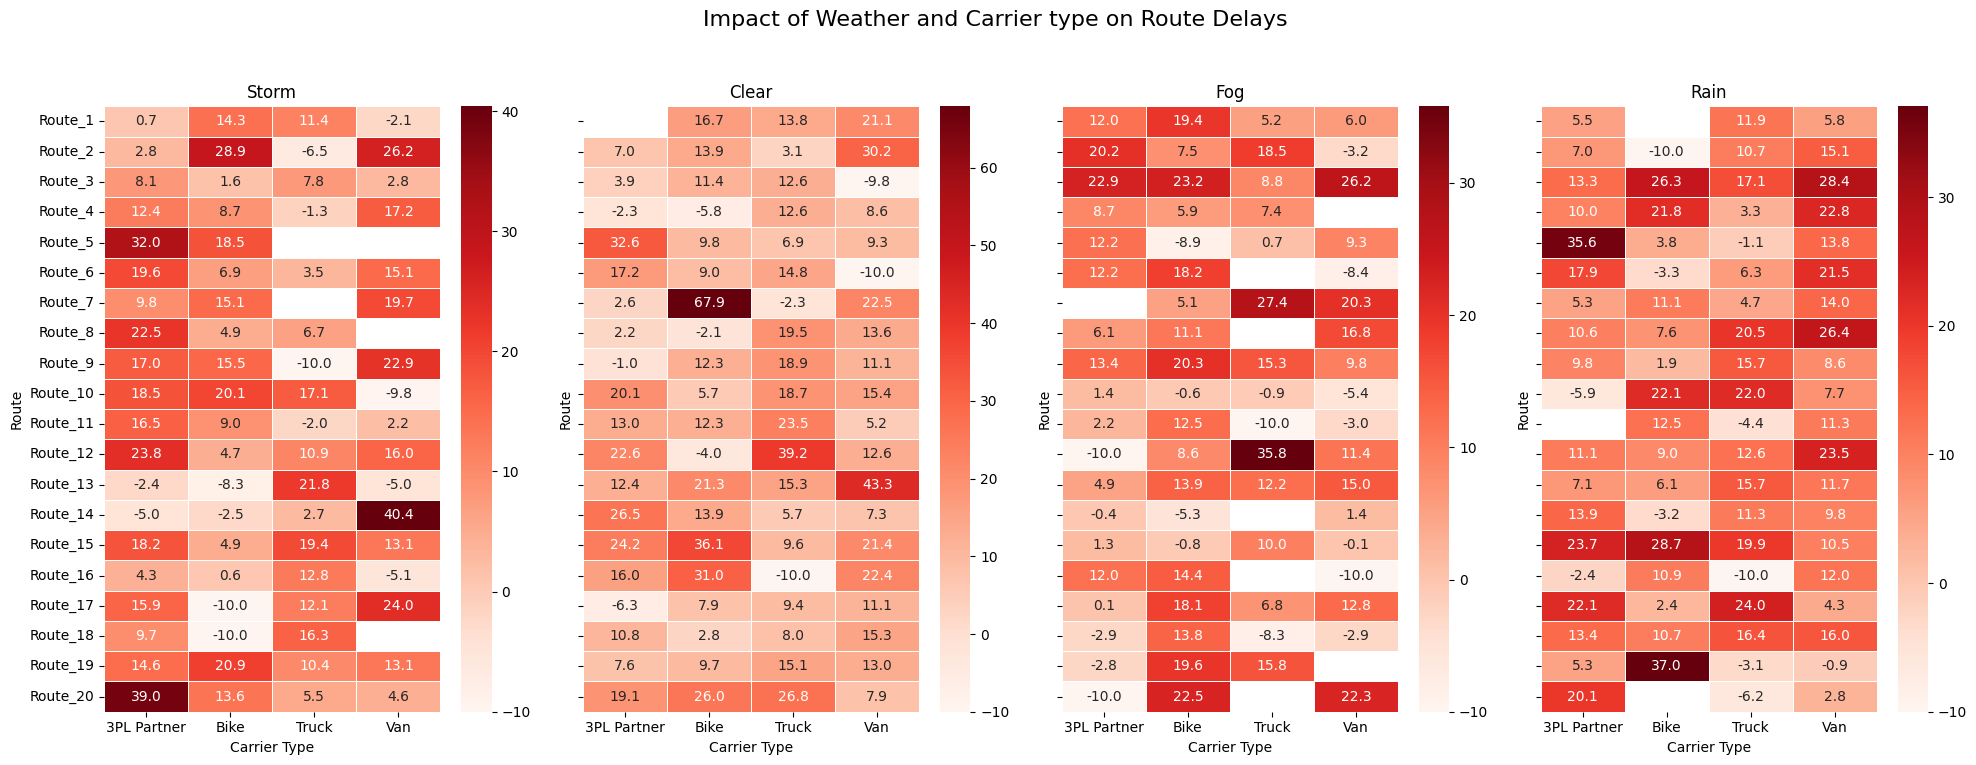

In [158]:
"""
This analysis identifies how different combinations of weather, routes, and carrier types impact delivery timing. It highlights specific 
conditions that cause delays versus those that remain on schedule.
"""

# Extract route number for sorting
df_merged['route_number'] = df_merged['route_name'].str.extract(r'(\d+)').astype(int)

# Get unique weather conditions
weather_conditions = df_merged['weather_condition'].unique()

# Set up the grid
num_conditions = len(weather_conditions)
fig, axes = plt.subplots(1, num_conditions, figsize=(5*num_conditions, 8), sharey=True)

# Main Title for the entire visualization
fig.suptitle("Impact of Weather and Carrier type on Route Delays", fontsize=16)

for i, weather in enumerate(weather_conditions):
    # Filter data for this weather
    weather_df = df_merged[df_merged['weather_condition'] == weather]
    
    # Create pivot table: rows = route_name, columns = carrier_type, values = avg delay
    pivot = weather_df.pivot_table(
        index='route_name',
        columns='carrier_type',
        values='delay_minutes',
        aggfunc='mean'
    )
    
    # Reindex pivot by sequential route number
    route_order = weather_df[['route_name', 'route_number']].drop_duplicates().sort_values('route_number')['route_name']
    pivot = pivot.reindex(route_order)
    
    # Plot heatmap
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".1f",
        cmap="Reds",
        linewidths=0.5,
        ax=axes[i]
    )
    axes[i].set_title(f"{weather}")
    axes[i].set_xlabel("Carrier Type")
    axes[i].set_ylabel("Route")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

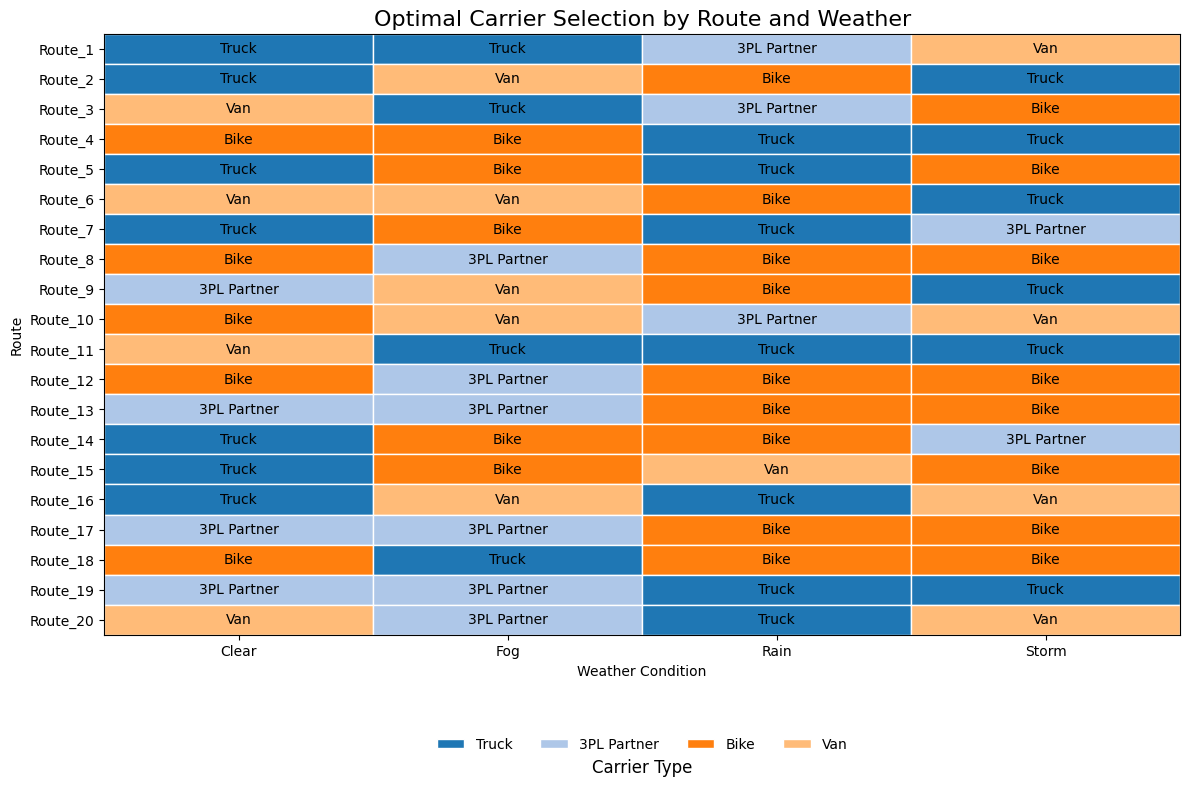

In [159]:
"""
This recommendation matrix identifies the most efficient carrier for each route under specific weather conditions. By following these selections,
delivery operations can minimize delays and optimize timing across the network.
"""

# Filter routes 1-20 and extract route number
df_merged['route_number'] = df_merged['route_name'].str.extract(r'(\d+)').astype(int)
df_filtered = df_merged[df_merged['route_number'].between(1,20)]

# Find best carrier per route per weather
best_carrier_list = []

for route in df_filtered['route_name'].unique():
    route_df = df_filtered[df_filtered['route_name'] == route]
    for weather in route_df['weather_condition'].unique():
        weather_df = route_df[route_df['weather_condition'] == weather]
        grouped = weather_df.groupby('carrier_type')['delay_minutes'].mean()
        best_carrier = grouped.idxmin()
        best_carrier_list.append({
            'route_name': route,
            'route_number': route_df['route_number'].iloc[0],  
            'weather_condition': weather,
            'best_carrier': best_carrier
        })

best_carrier_df = pd.DataFrame(best_carrier_list)

# Pivot for plotting
pivot = best_carrier_df.pivot(index='route_name', columns='weather_condition', values='best_carrier')

# Reindex pivot to arrange routes sequentially
route_order = best_carrier_df[['route_name','route_number']].drop_duplicates().sort_values('route_number')['route_name']
pivot = pivot.reindex(route_order)

# Assign a color to each carrier 
carrier_list = best_carrier_df['best_carrier'].unique()
colors = sns.color_palette("tab20", len(carrier_list))
carrier_color_dict = {carrier: colors[i] for i, carrier in enumerate(carrier_list)}

# Plot matrix with colors
fig, ax = plt.subplots(figsize=(12,8))

for i, route in enumerate(pivot.index):
    for j, weather in enumerate(pivot.columns):
        carrier = pivot.loc[route, weather]
        color = carrier_color_dict[carrier]
        rect = plt.Rectangle([j, i], 1, 1, facecolor=color, edgecolor='white')
        ax.add_patch(rect)
        ax.text(j+0.5, i+0.5, carrier, ha='center', va='center', fontsize=10, color='black')

# Formal and simple formatting
ax.set_xlim(0, len(pivot.columns))
ax.set_ylim(0, len(pivot.index))
ax.set_xticks(np.arange(len(pivot.columns)) + 0.5)
ax.set_xticklabels(pivot.columns, rotation=0)
ax.set_yticks(np.arange(len(pivot.index)) + 0.5)
ax.set_yticklabels(pivot.index)
ax.set_title("Optimal Carrier Selection by Route and Weather", fontsize=16)
ax.set_xlabel("Weather Condition")
ax.set_ylabel("Route")

ax.invert_yaxis()

# Legend for carriers
legend_elements = [Patch(facecolor=carrier_color_dict[c], edgecolor='white', label=c) for c in carrier_list]
legend = ax.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(carrier_list), frameon=False)
plt.text(0.5, -0.22, "Carrier Type", ha='center', va='center', transform=ax.transAxes, fontsize=12)

plt.tight_layout()
plt.show()

In [160]:
""" 
To evaluate the effectiveness of the recommended delivery strategy, it is necessary to identify the optimal carrier for each route under different weather conditions. This step extracts relevant route data, determines the best-performing carrier based on minimum average delay, and organizes the results in a structured format for comparison and further analysis.
"""

# Extract route numbers and limit analysis to routes 1–20
df_merged['route_number'] = df_merged['route_name'].str.extract(r'(\d+)').astype(int)
df_filtered = df_merged[df_merged['route_number'].between(1, 20)]

# Determine the best carrier (minimum average delay) for each route and weather condition
best_carrier_list = []

for route in df_filtered['route_name'].unique():
    route_df = df_filtered[df_filtered['route_name'] == route]
    
    for weather in route_df['weather_condition'].unique():
        weather_df = route_df[route_df['weather_condition'] == weather]
        
        grouped = weather_df.groupby('carrier_type')['delay_minutes'].mean()
        best_carrier = grouped.idxmin()
        
        best_carrier_list.append({
            'route_name': route,
            'weather_condition': weather,
            'best_carrier': best_carrier
        })

# Convert results into a DataFrame
best_carrier_df = pd.DataFrame(best_carrier_list)

# Create a wide-format table for easy visualization and lookup
best_carrier_wide = best_carrier_df.pivot(
    index='route_name',
    columns='weather_condition',
    values='best_carrier'
).reset_index()

# Remove unnecessary column index name created by pivot
best_carrier_wide.columns.name = None

# Extract route numbers again to arrange routes sequentially
best_carrier_wide['route_number'] = (
    best_carrier_wide['route_name'].str.extract(r'(\d+)').astype(int)
)

# Sort routes sequentially and clean up helper column
best_carrier_wide = (
    best_carrier_wide
    .sort_values('route_number')
    .drop(columns='route_number')
    .reset_index(drop=True)
)

best_carrier_wide

,route_name,Clear,Fog,Rain,Storm
0,Route_1,Truck,Truck,3PL Partner,Van
1,Route_2,Truck,Van,Bike,Truck
2,Route_3,Van,Truck,3PL Partner,Bike
3,Route_4,Bike,Bike,Truck,Truck
4,Route_5,Truck,Bike,Truck,Bike
5,Route_6,Van,Van,Bike,Truck
6,Route_7,Truck,Bike,Truck,3PL Partner
7,Route_8,Bike,3PL Partner,Bike,Bike
8,Route_9,3PL Partner,Van,Bike,Truck
9,Route_10,Bike,Van,3PL Partner,Van


In [161]:
""" 
Computes route-wise delivery delays before and after applying the recommended carrier strategy in order to quantify operational improvement and 
measure the effectiveness of the proposed solution. 
"""

# Convert recommendation table into long format for merging
best_carrier_long = best_carrier_wide.melt(
    id_vars='route_name',
    var_name='weather_condition',
    value_name='recommended_carrier'
)

# Attach recommended carrier information to each delivery record
df_eval = df_merged.merge(
    best_carrier_long,
    on=['route_name', 'weather_condition'],
    how='left'
)

# Calculate historical average delay for each carrier by route and weather
historical_delay = df_merged.groupby(
    ['route_name','weather_condition','carrier_type']
)['delay_minutes'].mean().reset_index()

# Rename columns to match recommendation structure
historical_delay.rename(
    columns={
        'carrier_type': 'recommended_carrier',
        'delay_minutes': 'recommended_delay'
    },
    inplace=True
)

# Merge historical performance of recommended carrier
df_eval = df_eval.merge(
    historical_delay,
    on=['route_name','weather_condition','recommended_carrier'],
    how='left'
)

# Use existing delay when historical recommendation data is unavailable
df_eval['recommended_delay'] = df_eval['recommended_delay'].fillna(
    df_eval['delay_minutes']
)

# Calculate average delay before applying recommendations
before = df_eval.groupby('route_name')['delay_minutes'].mean()

# Calculate expected delay after applying recommendations
after = df_eval.groupby('route_name')['recommended_delay'].mean()

# Combine results for comparison
results = pd.DataFrame({
    'Current_Avg_Delay': before,
    'Proposed_Avg_Delay': after
})

# Compute delay reduction in minutes
results['Delay_Reduction'] = (
    results['Current_Avg_Delay'] - results['Proposed_Avg_Delay']
)

# Compute percentage improvement in delays
results['Percent_Reduction'] = (
    results['Delay_Reduction'] /
    results['Current_Avg_Delay'] * 100
)

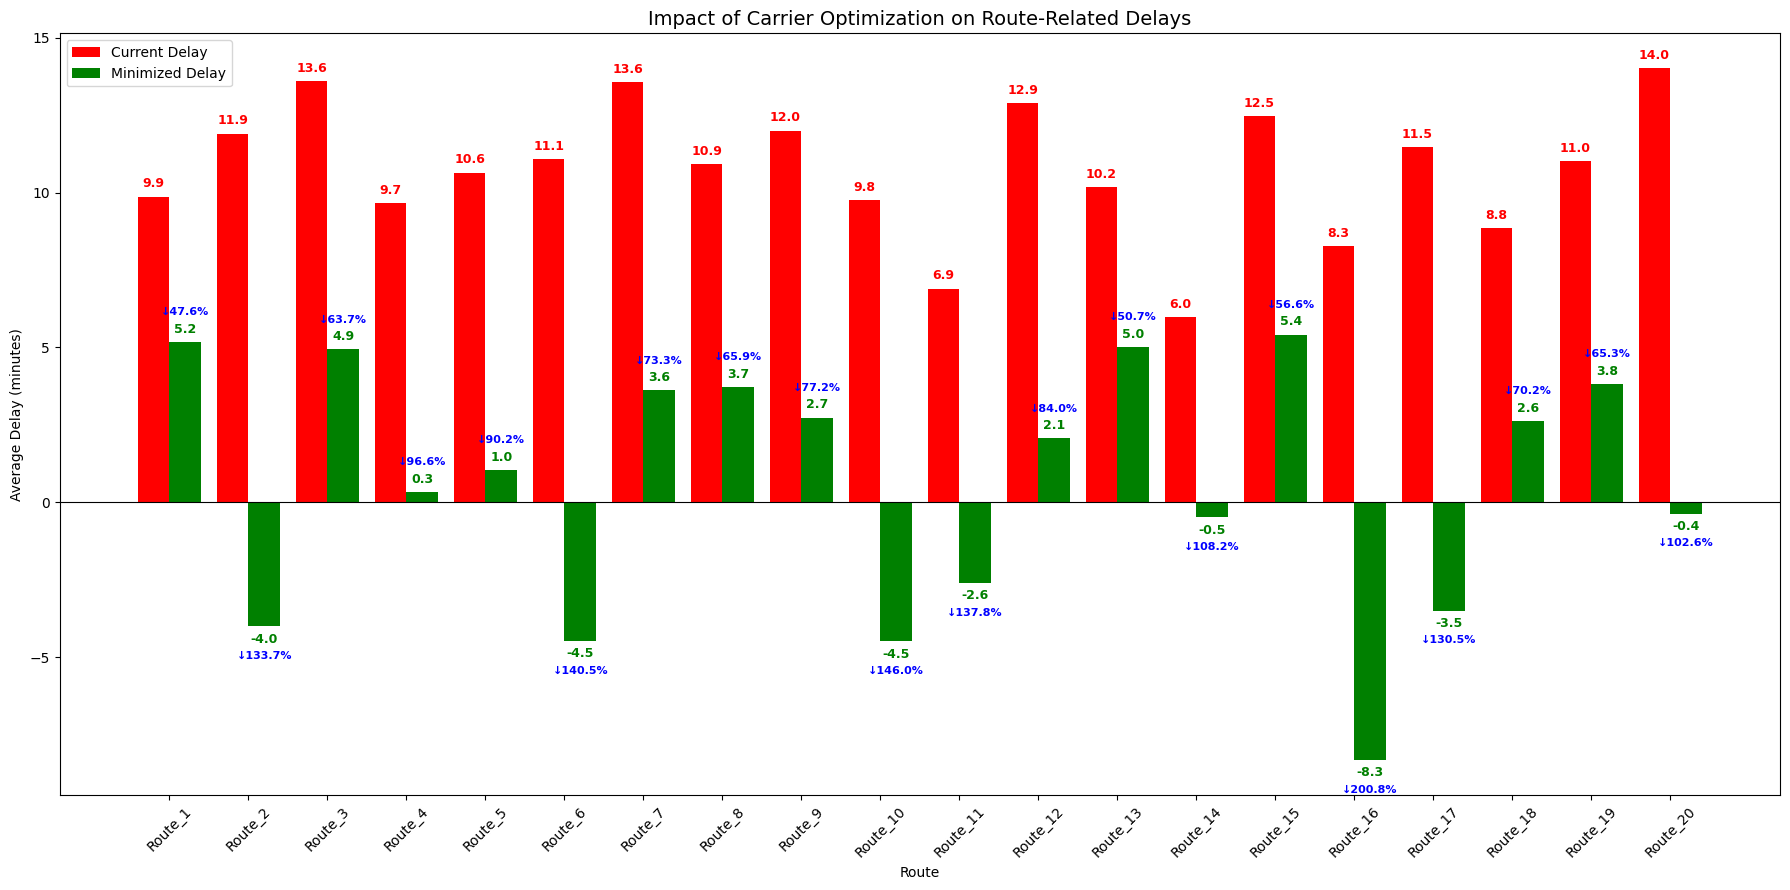

In [162]:
"""
This visual comparison measures how delivery performance changes when using recommended carriers versus current ones. It highlights time saved 
in minutes and shows the percentage of improvement for every delivery path.
"""

# Prepare data and sort routes numerically 
results_sorted = results.copy().reset_index()
results_sorted.rename(columns={'index': 'route_name'}, inplace=True)
results_sorted['route_num'] = results_sorted['route_name'].str.extract(r'(\d+)').astype(int)
results_sorted = results_sorted.sort_values('route_num').set_index('route_name')

routes = results_sorted.index.tolist()
current_delay = results_sorted['Current_Avg_Delay'].values
proposed_delay = results_sorted['Proposed_Avg_Delay'].values

# Visual configuration
current_bar_color, proposed_bar_color, blue_label_color = "red", "green", "blue"
value_fontsize, bar_width, value_offset = 9, 0.4, 0.2 

x = np.arange(len(routes))
plt.figure(figsize=(18, 9))

# Plot comparative bars
bars1 = plt.bar(x - bar_width/2, current_delay, width=bar_width, 
                color=current_bar_color, label="Current Delay")
bars2 = plt.bar(x + bar_width/2, proposed_delay, width=bar_width, 
                color=proposed_bar_color, label="Minimized Delay")

# Add numeric labels 
def add_numeric_labels(bars, color):
    for bar in bars:
        height = bar.get_height()
        y_pos = height + value_offset if height >= 0 else height - value_offset
        v_align = 'bottom' if height >= 0 else 'top'

        plt.text(
            bar.get_x() + bar.get_width()/2, y_pos, f"{height:.1f}",
            ha='center', va=v_align, fontsize=value_fontsize, 
            color=color, fontweight='bold'
        )

# Add blue percentage labels indicating improvement/reduction
def add_percentage_labels():
    for i in range(len(routes)):
        before, after = current_delay[i], proposed_delay[i]
        
        if before != 0:
            reduction_pct = ((before - after) / before) * 100
            arrow = "↓" if reduction_pct >= 0 else "↑"
            
            # Stack blue labels relative to the 'after' delay bars
            y_blue = after + (value_offset * 4) if after >= 0 else after - (value_offset * 4)
            v_align_blue = 'bottom' if after >= 0 else 'top'

            plt.text(
                x[i] + bar_width/2, y_blue, f"{arrow}{abs(reduction_pct):.1f}%",
                ha='center', va=v_align_blue, fontsize=value_fontsize - 1,
                color=blue_label_color, fontweight='bold'
            )

add_numeric_labels(bars1, current_bar_color)
add_numeric_labels(bars2, proposed_bar_color)
add_percentage_labels()

# Final chart styling
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(x, routes, rotation=45)
plt.ylabel("Average Delay (minutes)")
plt.xlabel("Route")
plt.title("Impact of Carrier Optimization on Route-Related Delays", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

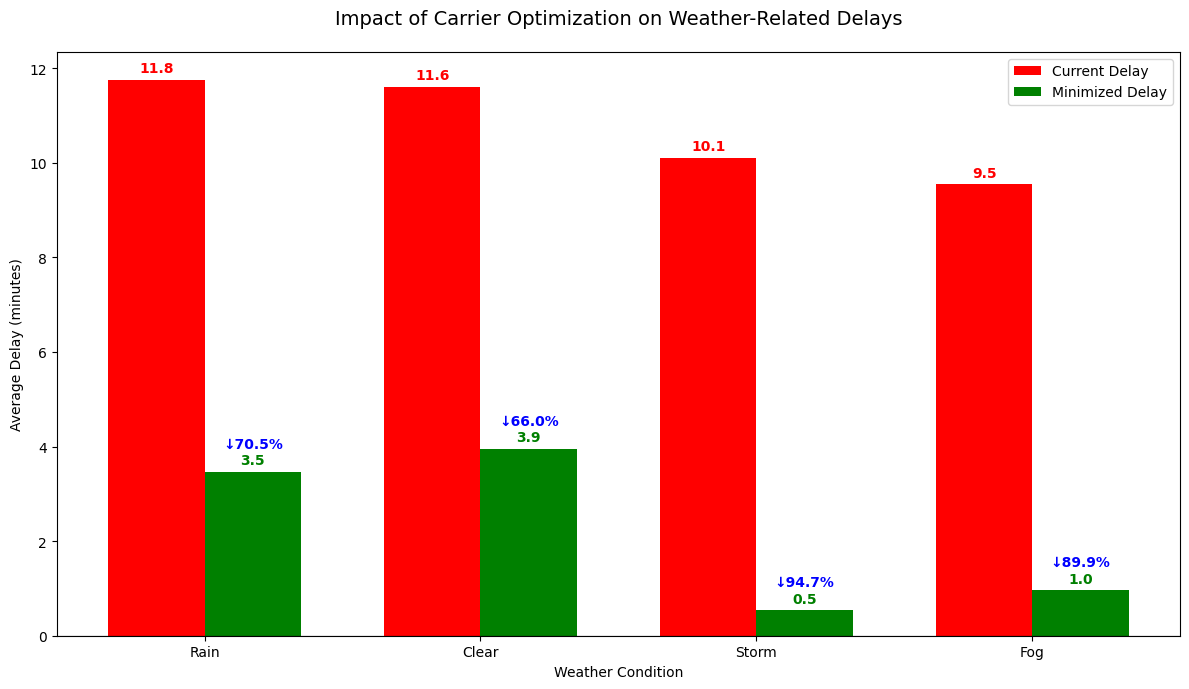

In [163]:
"""
This analysis evaluates how selecting the most efficient carrier for each weather condition reduces delivery wait times. It compares current 
average delays against projected results, highlighting the percentage of time saved across different weather environments.
"""
# Filter and identify Best Carriers 
df_filtered = df_merged[df_merged['route_number'].between(1, 20)].copy()

best_carrier_list = []
for route in df_filtered['route_name'].unique():
    route_df = df_filtered[df_filtered['route_name'] == route]
    for weather in route_df['weather_condition'].unique():
        weather_df = route_df[route_df['weather_condition'] == weather]
        best_carrier = weather_df.groupby('carrier_type')['delay_minutes'].mean().idxmin()
        best_carrier_list.append({
            'route_name': route,
            'weather_condition': weather,
            'recommended_carrier': best_carrier
        })

best_carrier_df = pd.DataFrame(best_carrier_list)

# Calculate 'Before' and 'After'
weather_before = df_filtered.groupby('weather_condition')['delay_minutes'].mean()
df_eval = df_filtered.merge(best_carrier_df, on=['route_name', 'weather_condition'])
df_after_only = df_eval[df_eval['carrier_type'] == df_eval['recommended_carrier']]
weather_after = df_after_only.groupby('weather_condition')['delay_minutes'].mean()

# Prepare impact dataframe and calculate percentage reduction
impact_df = pd.DataFrame({'Before': weather_before, 'After': weather_after}).fillna(0)
impact_df['Reduction_%'] = ((impact_df['Before'] - impact_df['After']) / impact_df['Before']) * 100
impact_df = impact_df.sort_values(by='Before', ascending=False)

# Plotting
x = np.arange(len(impact_df.index))
width = 0.35
value_offset = 0.1  

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, impact_df['Before'], width, label='Current Delay', color='red')
rects2 = ax.bar(x + width/2, impact_df['After'], width, label='Minimized Delay', color='green')

# Function to add numeric labels (Red/Green) and Blue percentage labels
def add_all_labels():
    for i in range(len(impact_df)):
        # BEFORE Bar (Red)
        h_before = impact_df['Before'].iloc[i]
        va_b = 'bottom' if h_before >= 0 else 'top'
        y_b = h_before + value_offset if h_before >= 0 else h_before - value_offset
        ax.text(x[i] - width/2, y_b, f'{h_before:.1f}', ha='center', va=va_b, color='red', fontweight='bold')

        # AFTER Bar (Green)
        h_after = impact_df['After'].iloc[i]
        va_a = 'bottom' if h_after >= 0 else 'top'
        y_a = h_after + value_offset if h_after >= 0 else h_after - value_offset
        ax.text(x[i] + width/2, y_a, f'{h_after:.1f}', ha='center', va=va_a, color='green', fontweight='bold')

        # REDUCTION % (Blue)
        red_pct = impact_df['Reduction_%'].iloc[i]
        arrow = "↓" if red_pct >= 0 else "↑"
        # Place blue label slightly higher than the green numeric label
        y_blue = y_a + (value_offset * 3.5) if h_after >= 0 else y_a - (value_offset * 3.5)
        ax.text(x[i] + width/2, y_blue, f'{arrow}{abs(red_pct):.1f}%', 
                ha='center', va=va_a, color='blue', fontweight='bold', fontsize=10)

add_all_labels()

# Final Formatting
ax.set_ylabel('Average Delay (minutes)')
ax.set_xlabel('Weather Condition')
ax.set_title('Impact of Carrier Optimization on Weather-Related Delays', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(impact_df.index)
ax.axhline(0, color='black', linewidth=0.8) # Zero line for context
ax.legend()

plt.tight_layout()
plt.show()

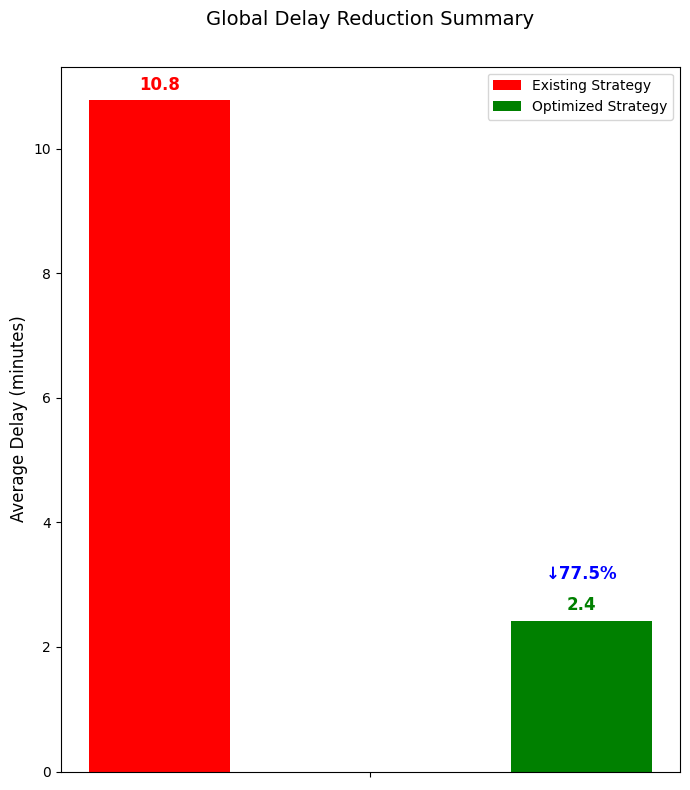

In [164]:
"""This analysis evaluates the total reduction in delivery delays across the entire fleet. It calculates a baseline average delay and compares it 
against the results of implementing optimized carrier selections, providing a final percentage of improvement."""
# Data Preparation & Logic 
df_filtered = df_merged[df_merged['route_number'].between(1, 20)].copy()

# Identify best carrier per route/weather 
best_carrier_list = []
for route in df_filtered['route_name'].unique():
    route_df = df_filtered[df_filtered['route_name'] == route]
    for weather in route_df['weather_condition'].unique():
        weather_df = route_df[route_df['weather_condition'] == weather]
        # Find carrier with absolute lowest average delay for this specific scenario
        best_carrier = weather_df.groupby('carrier_type')['delay_minutes'].mean().idxmin()
        best_carrier_list.append({
            'route_name': route,
            'weather_condition': weather,
            'recommended_carrier': best_carrier
        })
best_carrier_df = pd.DataFrame(best_carrier_list)

# BEFORE: Average of every single delivery in the dataset
overall_delay_before = df_filtered['delay_minutes'].mean()

# AFTER: Simulating the performance if only recommended carriers were used
df_eval = df_filtered.merge(best_carrier_df, on=['route_name', 'weather_condition'])
df_after_only = df_eval[df_eval['carrier_type'] == df_eval['recommended_carrier']]
overall_delay_after = df_after_only['delay_minutes'].mean()

# PERCENTAGE REDUCTION
overall_reduction_pct = ((overall_delay_before - overall_delay_after) / overall_delay_before) * 100

# Visualization 
bar_width = 0.1
x = np.arange(1) 
value_offset = 0.1

fig, ax = plt.subplots(figsize=(7, 8))

# Plot bars
bar1 = ax.bar(x - bar_width/2 - 0.1, overall_delay_before, width=bar_width, color='red', label='Existing Strategy')
bar2 = ax.bar(x + bar_width/2 + 0.1, overall_delay_after, width=bar_width, color='green', label='Optimized Strategy')

# Function to handle numeric labels 
def add_summary_label(bar, value, color):
    height = bar.get_height()
    va = 'bottom' if height >= 0 else 'top'
    y_pos = height + value_offset if height >= 0 else height - value_offset
    ax.text(bar.get_x() + bar.get_width()/2, y_pos, f"{value:.1f}", 
            ha='center', va=va, color=color, fontweight='bold', fontsize=12)

add_summary_label(bar1[0], overall_delay_before, 'red')
add_summary_label(bar2[0], overall_delay_after, 'green')

# Add Blue Percentage Reduction Label
arrow = "↓" if overall_reduction_pct >= 0 else "↑"
y_blue = overall_delay_after + (value_offset * 6) if overall_delay_after >= 0 else overall_delay_after - (value_offset * 6)
ax.text(bar2[0].get_x() + bar2[0].get_width()/2, y_blue, 
        f"{arrow}{abs(overall_reduction_pct):.1f}%", 
        ha='center', va='bottom', color='blue', fontweight='bold', fontsize=12)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels([''], fontsize=12)
ax.set_ylabel("Average Delay (minutes)", fontsize=12)
ax.set_title("Global Delay Reduction Summary", fontsize=14, pad=30)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

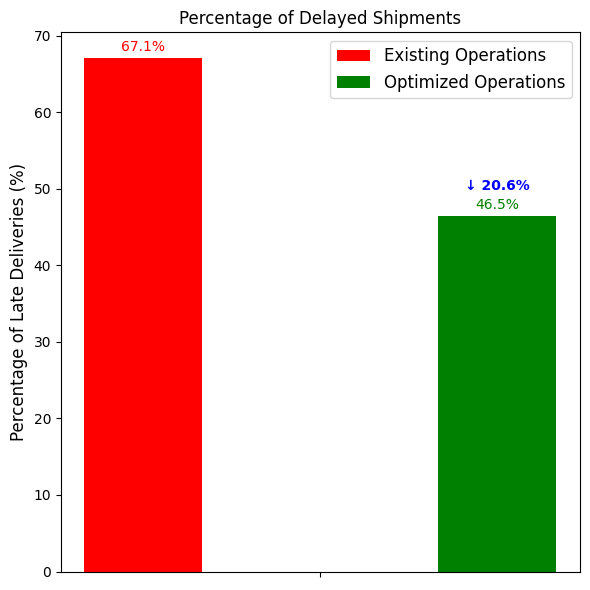

In [ ]:
"""
This plot shows the effectivness of the recommended strategy, as well as the percentage of reduction in delay, post-application of the strategy.
"""

# Extract numeric route number for sorting
df_merged['route_number'] = df_merged['route_name'].str.extract(r'(\d+)').astype(int)
df_filtered = df_merged[df_merged['route_number'].between(1, 20)]

# Find recommended carrier per route per weather
best_carrier_list = []

for route in df_filtered['route_name'].unique():
    route_df = df_filtered[df_filtered['route_name'] == route]
    for weather in route_df['weather_condition'].unique():
        weather_df = route_df[route_df['weather_condition'] == weather]
        # Find carrier with lowest average delay for this route and weather
        grouped = weather_df.groupby('carrier_type')['delay_minutes'].mean()
        best_carrier = grouped.idxmin()
        best_carrier_list.append({
            'route_name': route,
            'weather_condition': weather,
            'recommended_carrier': best_carrier
        })

best_carrier_df = pd.DataFrame(best_carrier_list)

# Compute % of late deliveries using delivery_status
# Before recommendation: % of delayed deliveries
percent_late_before = (df_filtered['delivery_status'] == 'Delayed').mean() * 100

# After recommendation: consider only rows with the recommended carrier
df_recommended = df_filtered.merge(
    best_carrier_df,
    on=['route_name','weather_condition'],
    how='left'
)

df_recommended['match'] = df_recommended['carrier_type'] == df_recommended['recommended_carrier']

percent_late_after = (df_recommended[df_recommended['match']]['delivery_status'] == 'Delayed').mean() * 100

# % reduction
percent_reduction = percent_late_before - percent_late_after

# Plot two-bar chart
bar_width = 0.1      
gap = 0.2            
labels = ['']        
x = np.arange(1)     
delays = [percent_late_before, percent_late_after]
colors = ['red', 'green']

fig, ax = plt.subplots(figsize=(6,6))

# Plot bars with gap
bars1 = ax.bar(x - bar_width/2 - gap/2, percent_late_before, width=bar_width, color='red', label='Existing Operations')
bars2 = ax.bar(x + bar_width/2 + gap/2, percent_late_after, width=bar_width, color='green', label='Optimized Operations')

# Add values on top of bars
for bar, color, value in zip([bars1[0], bars2[0]], colors, delays):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2, 
        height + 0.5, 
        f"{value:.1f}%", 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        color=color
    )

# Add % reduction on top of green bar
ax.text(
    bars2[0].get_x() + bars2[0].get_width()/2, 
    bars2[0].get_height() + 3,  
    f"↓ {percent_reduction:.1f}%", 
    ha='center', 
    va='bottom', 
    fontsize=10, 
    color='blue', 
    fontweight='bold'
)

# Labels, title, legend
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylabel("Percentage of Late Deliveries (%)", fontsize=12)
ax.set_title("Percentage of Delayed Shipments", fontsize=12)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()